## THỰC HÀNH MHNC LAB 08


## NGUYỄN MINH HOÀNG 18110095

In [ ]:
!pip install ipyplot

In [ ]:
import ipyplot
import numpy as np
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras import layers
from tensorflow.keras.layers import (Input, Dense, Reshape, Concatenate, 
                                     BatchNormalization, LeakyReLU, Dropout, Activation,
                                     Conv2DTranspose, Conv2D, Flatten)
# from tensorflow.keras.models import Model
from tensorflow.keras import Model



        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `base_64` param to `True`.
        


In [ ]:
batch_size = 128 # batch size để đưa vào mô hình huấn luyện
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data() #đọc dữ liệu
all_digits = np.concatenate([x_train, x_test]) 
labels = np.concatenate([y_train,y_test])
all_digits = (all_digits.astype("float32")-127.5) / 127.5 #đưa tấm hình về [-1,1]
all_digits = np.reshape(all_digits,(-1,28,28,1)) #reshape toàn bộ dữ liệu lại
all_digits = tf.data.Dataset.from_tensor_slices(all_digits) #Đưa dữ liệu về dạng tensor

from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoder.fit(np.reshape(np.array(range(0,10)),[-1,1]))
onehot_encoded = onehot_encoder.transform(np.reshape(labels,[-1,1]))
all_labels = tf.data.Dataset.from_tensor_slices(onehot_encoded)

dataset = tf.data.Dataset.zip((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(32) #shuffle dữ liệu mỗi lần đưa vào mô hình

##Bài tập
###1. Dựa vào mô hinhd CGAN ở trên ở viết mô hình CGAN như ở phần dưới 



**DISCRIMINATOR**


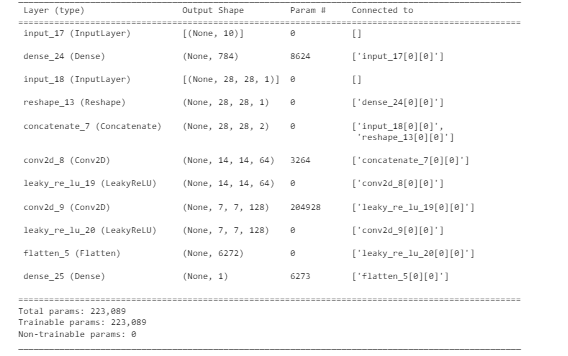

In [ ]:
#Mô hình mạng discriminator

Inputs = Input(shape=(28, 28, 1))
Labels = Input(shape=(10,))
LabelDense = Dense(units=784)(Labels)
LabelDense = Reshape(target_shape=(28,28,1))(LabelDense)

Discriminator = Concatenate()([Inputs, LabelDense])
Discriminator = Conv2D(filters=64,
                       kernel_size=[5,5],
                       strides=[2,2],
                       padding="same")(Discriminator)



Discriminator = LeakyReLU(alpha=0.2)(Discriminator)

Discriminator = Conv2D(filters = 128,
                       kernel_size=[5,5],
                       strides=[2,2],
                       padding="same")(Discriminator)


Discriminator = LeakyReLU(alpha=0.2)(Discriminator)

Discriminator = Flatten()(Discriminator)

Discriminator = Dense(units = 1 , 
                      activation = 'sigmoid')(Discriminator)

discriminator = Model(inputs=[Inputs, Labels], 
                               outputs=Discriminator)

discriminator.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 784)          8624        ['input_2[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 reshape (Reshape)              (None, 28, 28, 1)    0           ['dense[0][0]']                  
                                                                                              

**GENERATOR**


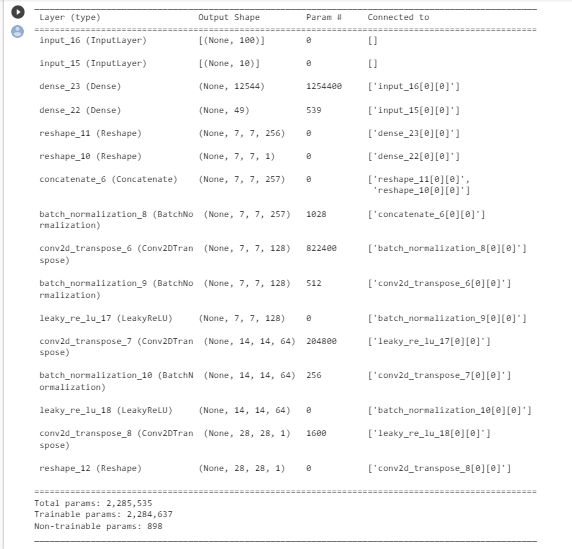

In [ ]:
#mô hình của mạng Generator
latten_dim = 100

Inputs = Input(shape=(latten_dim,))
Labels = Input(shape=(10,))

Generator1 = Dense(units=12544, 
                   use_bias= False)(Inputs)
Generator2 = Dense(units=49)(Labels)
Generator1 = Reshape(target_shape=(7,7,256))(Generator1)
Generator2 = Reshape(target_shape=(7,7,1))(Generator2)

Generator = Concatenate()([Generator1, Generator2])

Generator = BatchNormalization()(Generator)

Generator = Conv2DTranspose(filters=128,
                            kernel_size=[5,5],
                            strides=(1,1),
                            padding="same",
                            use_bias=False)(Generator)
Generator = BatchNormalization()(Generator)
Generator = LeakyReLU(alpha=0.2)(Generator)
Generator = Conv2DTranspose(filters=64,
                            kernel_size=[5,5],
                            strides=(2,2),
                            padding="same",
                            use_bias=False)(Generator)
Generator = BatchNormalization()(Generator)
Generator = LeakyReLU(alpha=0.2)(Generator)
Generator = Conv2DTranspose(filters=1,
                            kernel_size=[5,5],
                            strides=(2,2),
                            padding="same",
                            use_bias=False,
                            activation = "tanh")(Generator)
Generator = Reshape(target_shape=(28,28,1))(Generator)                            

generator = Model(inputs=[Inputs, Labels], outputs=Generator)

generator.summary()




Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 12544)        1254400     ['input_3[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 49)           539         ['input_4[0][0]']                
                                                                                            

In [ ]:
class Gan(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(Gan,self).__init__()
        self.discriminator=discriminator 
        self.generator=generator
        self.latent_dim=latent_dim
    def compile(self, d_optimizer, g_optimizer, loss_function):
        super(Gan,self).compile()
        self.d_optimizer=d_optimizer
        self.g_optimizer=g_optimizer
        self.loss_function=loss_function 
    def train_step(self, real_images):
        # tạo batch size từ dữ liệu đầu vào
        batch_size = tf.shape(real_images[0])[0]
        CLabel = real_images[1] 
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim)) #tạo noises theo phân phối chuẩn

        # Tạo ra ảnh giả từ mạng generator
        generated_images = self.generator([random_latent_vectors ,CLabel])

        # nối ảnh giả và ảnh thật làm bộ dữ liệu cho mô hình discriminator
        combined_images = tf.concat([generated_images, real_images[0]], axis=0)
        combined_CLabel = tf.concat([CLabel, CLabel], axis=0)
        # Ở đây đánh nhãn ảnh thật là 0, ảnh giả là 1
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # trick để add thêm noise cho nhãn
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # huấn luyện discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator([combined_images, combined_CLabel]) #Dự đoán 
            d_loss = self.loss_function(labels, predictions)  #Đưa kết quả dự đoán và grouth-truth vào hàm loss
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        ) #cập nhật weights cho mô hình discrimunator


        # lặp lại bước tạo noise như ở trên
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # tạo mộ bộ nhãn sao cho đều là 0 để đánh lừa discriminator
        misleading_labels = tf.zeros((batch_size, 1))

        # Train generator (lưu ý k update weights cho discriminator)
        with tf.GradientTape() as tape:
            predictions = self.discriminator([self.generator([random_latent_vectors, CLabel]), CLabel])
            g_loss = self.loss_function(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

In [ ]:
#overwrite callback để lúc huấn luyện xem ảnh in ra
from IPython.display import Image, display
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=4, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim)) #Tạo noises
        # labels=tf.constant([[1,0,0,0,0,0,0,0,0,0],
        #                    [0,1,0,0,0,0,0,0,0,0],
        #                    [0,0,1,0,0,0,0,0,0,0]])

        labels = tf.constant(
                            [[0,0,0,1,0,0,0,0,0,0],
                            [0,0,0,0,0,1,0,0,0,0],
                            [0,0,0,0,0,0,0,1,0,0],
                            [0,0,0,0,0,0,0,0,0,1] 
                             ])
        generated_images = self.model.generator([random_latent_vectors,labels]) #tạo ảnh
        generated_images = generated_images*127.5+127.5 #Đưa ảnh về [0,255]
        generated_images.numpy() 
        list_img = []
        print("epoch ",epoch + 1)
        for i in range(self.num_img):
            # img = keras.preprocessing.image.array_to_img(generated_images[i])
            # display(img) #in ảnh
            img = np.squeeze(generated_images[i], axis=2)
            list_img.append(img)
        ipyplot.plot_images(list_img)

###2. Trong quá trình training hãy in ra các số sau 3, 5, 7, 9

epoch  1



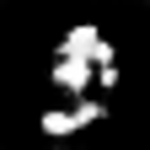
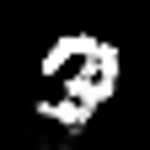
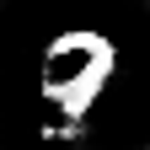
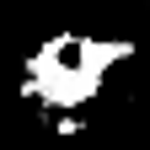


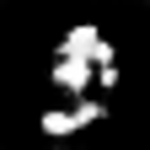
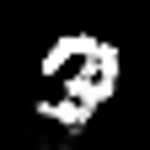
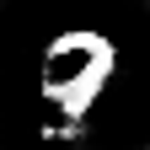
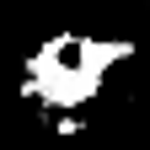

epoch  2



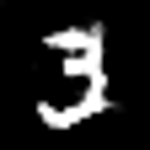
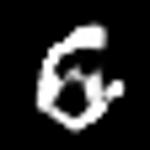
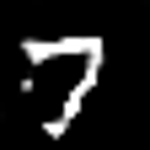
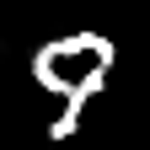


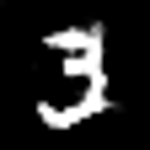
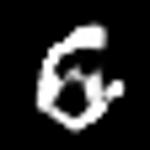
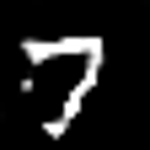
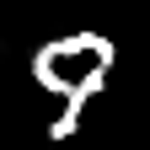

epoch  3



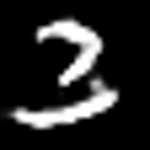
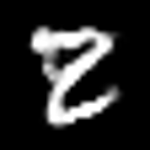
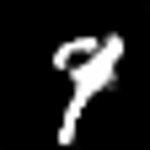
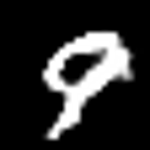


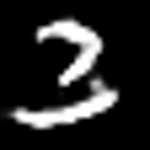
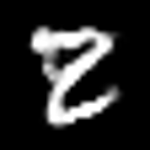
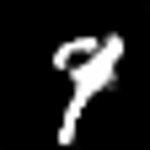
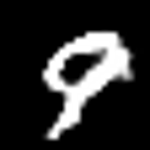

epoch  4



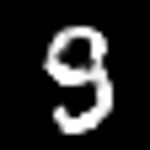
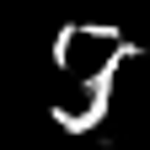
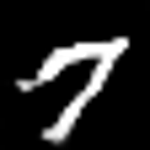
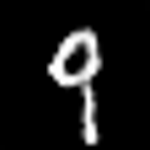


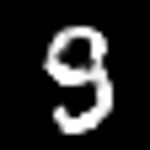
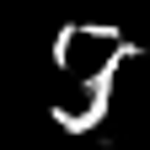
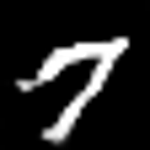
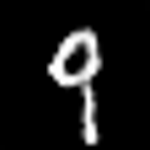

epoch  5



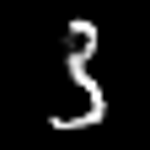
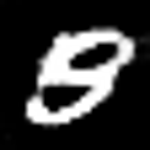
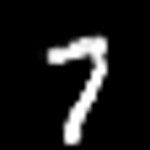
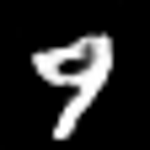


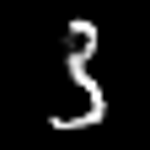
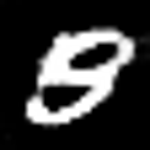
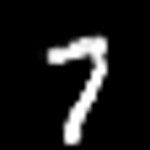
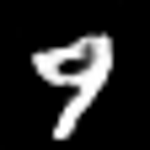

epoch  6



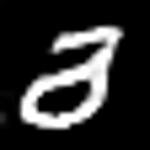
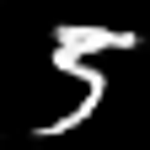
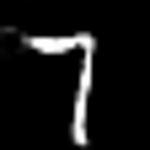
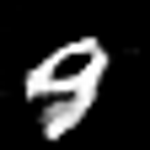


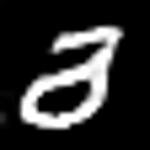
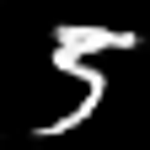
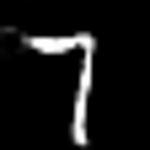
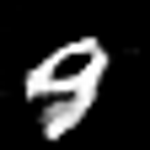

epoch  7



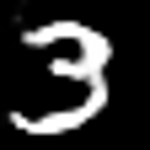
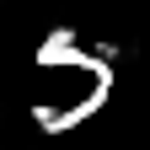
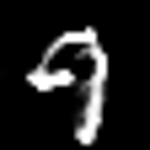
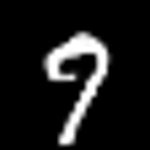


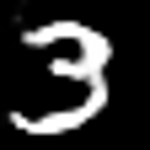
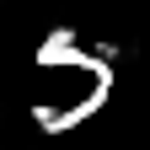
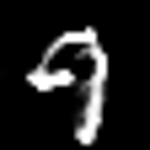
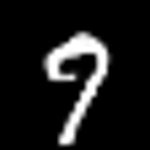

epoch  8



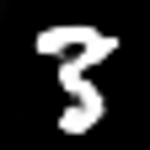
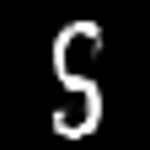
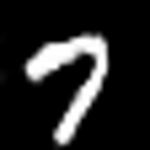
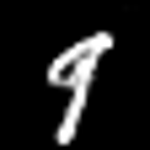


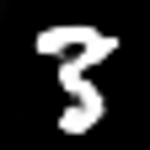
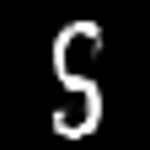
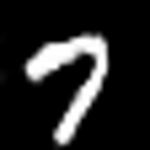
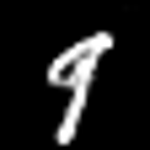

epoch  9



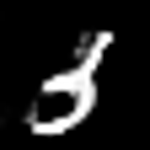
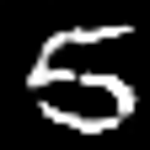
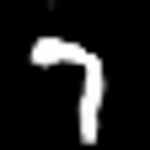
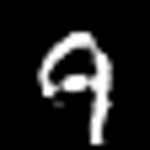


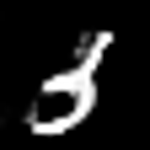
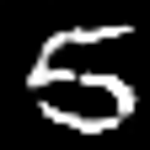
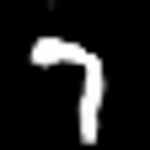
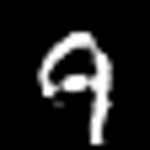

epoch  10



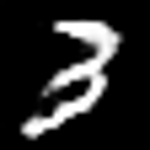
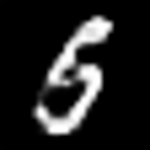
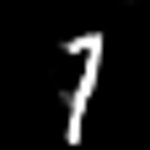
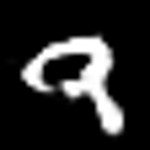


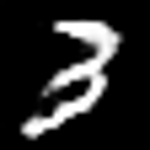
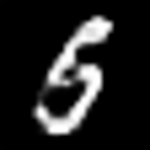
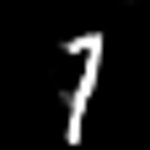
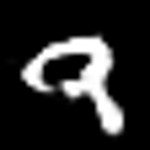

epoch  11



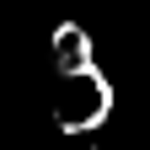
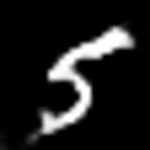
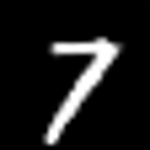
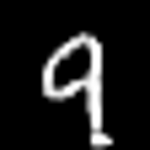


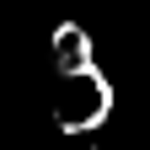
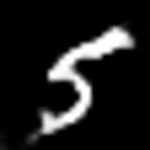
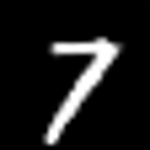
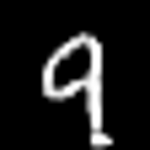

epoch  12



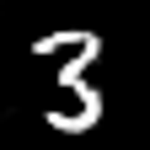
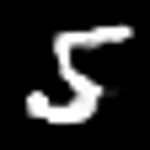
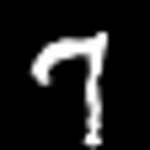
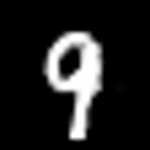


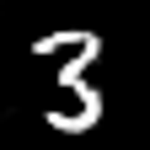
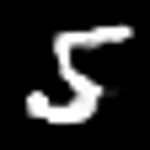
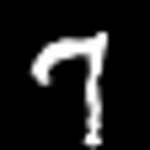
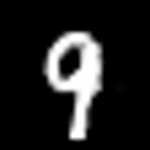

epoch  13



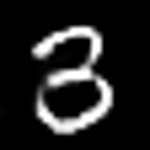
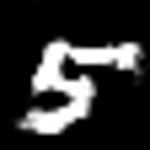
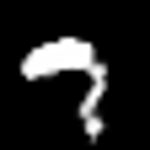
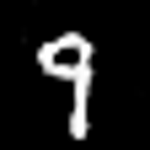


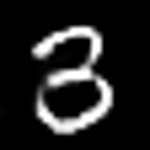
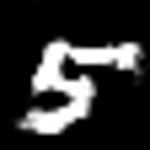
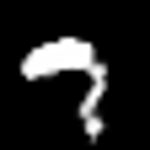
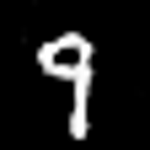

epoch  14



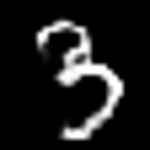
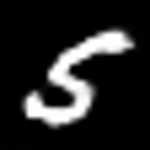
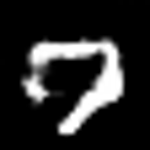
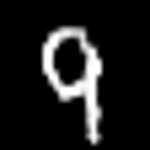


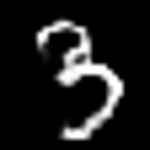
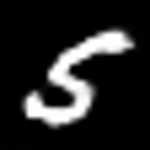
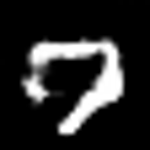
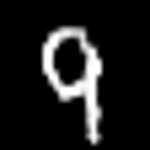

epoch  15



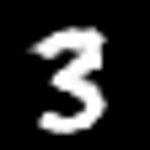
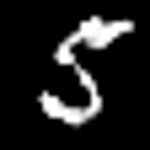
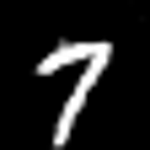
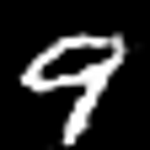


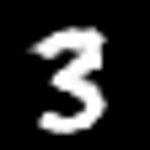
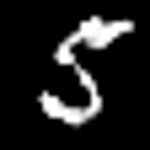
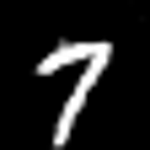
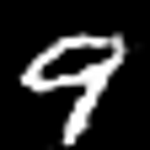

epoch  16



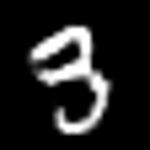
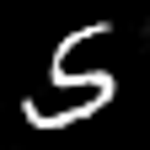
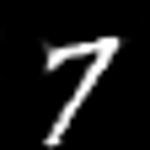
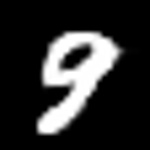


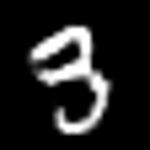
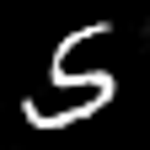
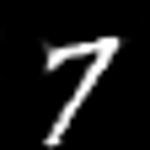
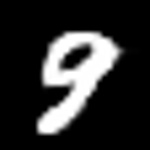

epoch  17



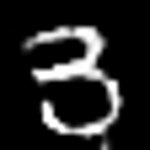
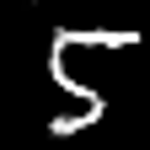
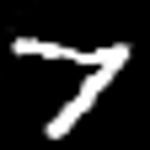
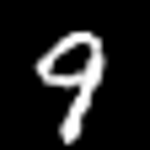


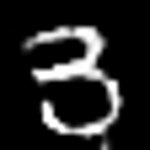
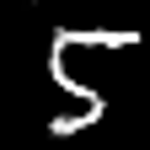
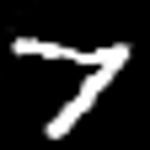
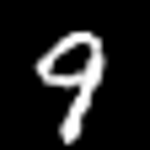

epoch  18



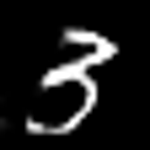
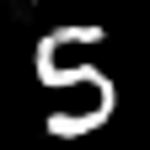
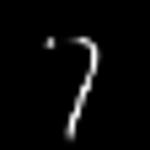
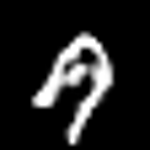


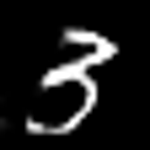
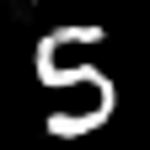
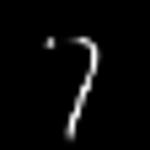
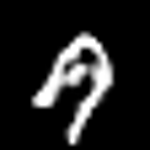

epoch  19



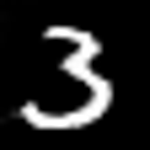
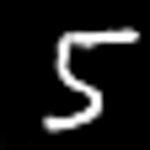
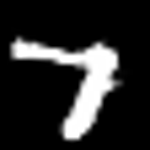
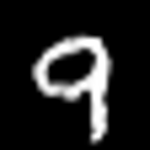


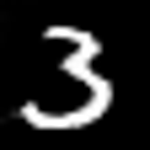
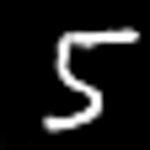
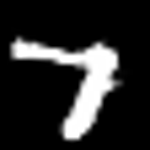
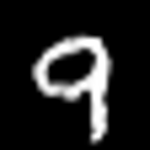

epoch  20



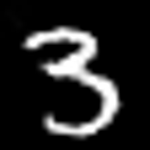
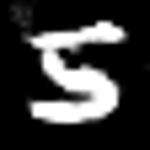
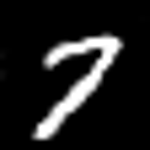
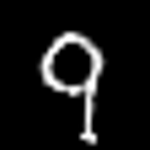


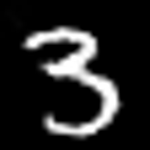
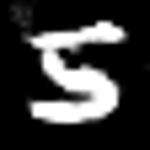
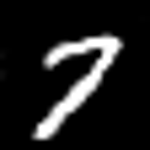
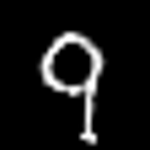

epoch  21



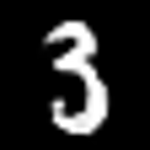
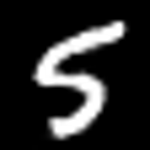
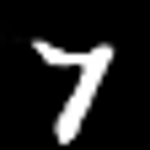
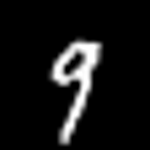


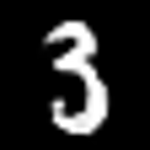
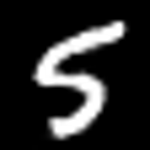
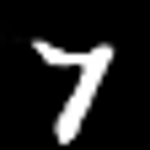
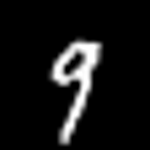

epoch  22



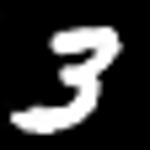
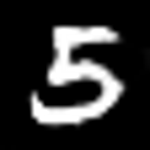
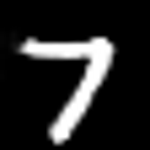
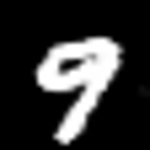


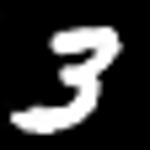
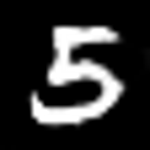
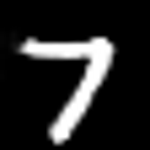
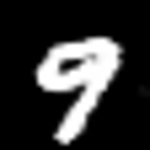

epoch  23



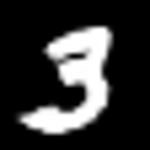
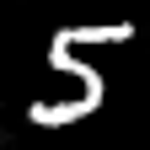
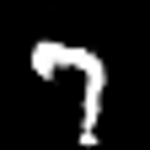
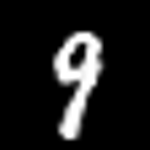


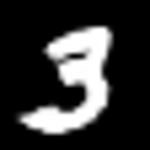
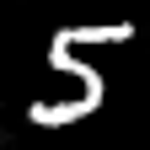
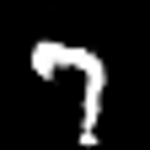
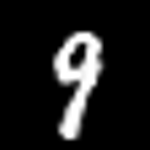

epoch  24



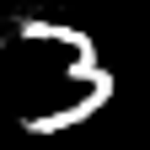
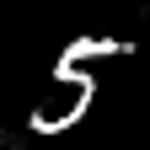
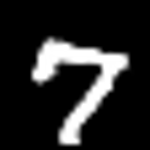
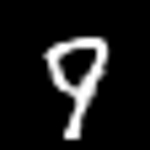


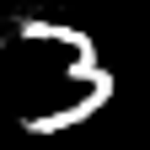
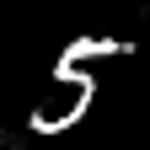
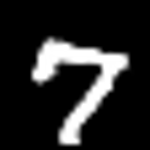
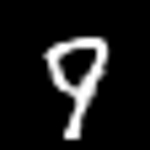

epoch  25



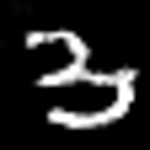
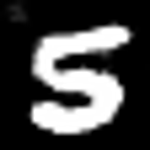
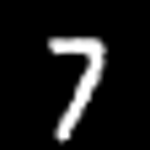
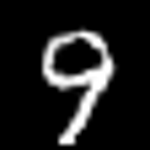


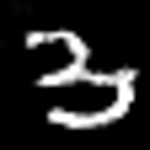
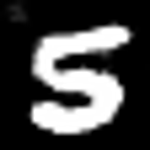
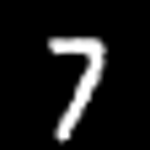
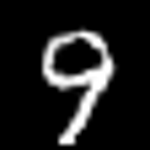

epoch  26



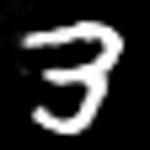
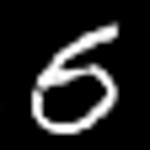
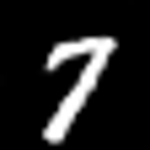
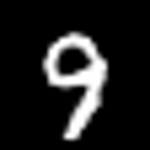


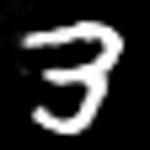
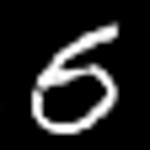
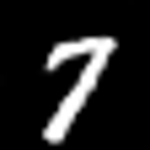
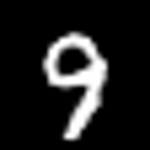

epoch  27



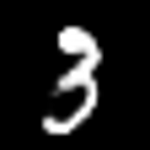
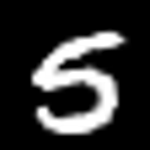
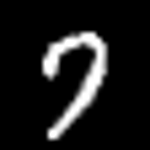
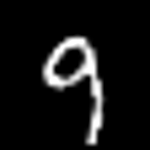


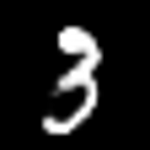
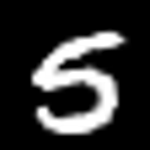
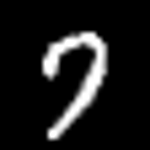
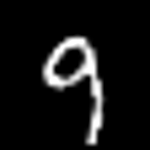

epoch  28



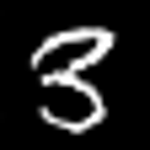
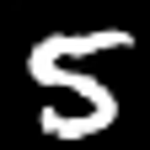
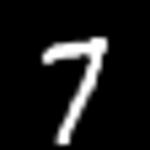
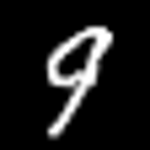


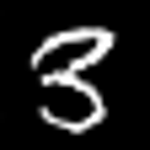
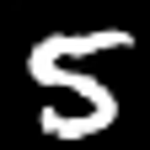
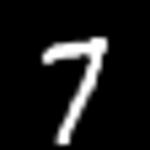
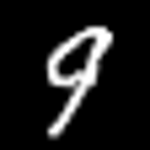

epoch  29



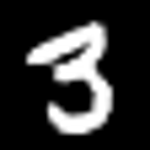
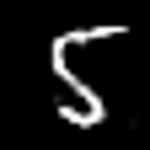
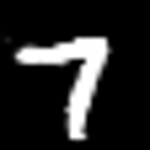
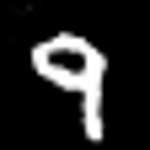


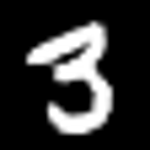
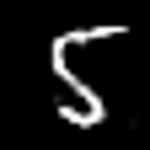
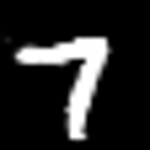
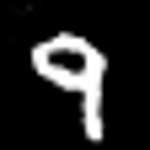

epoch  30



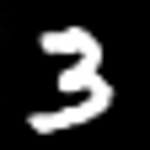
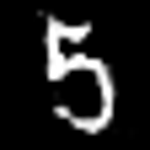
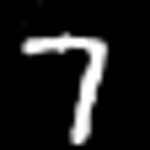
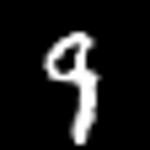


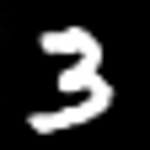
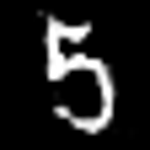
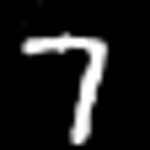
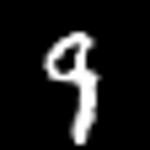

epoch  31



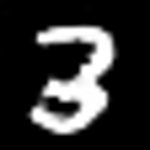
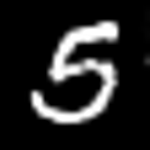
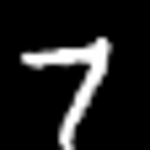
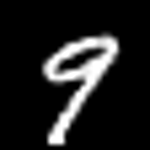


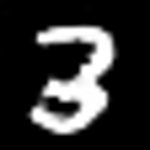
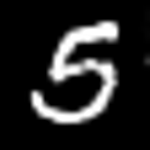
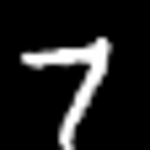
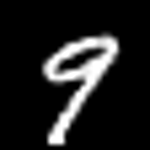

epoch  32



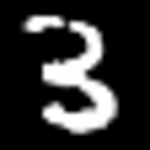
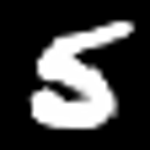
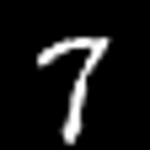
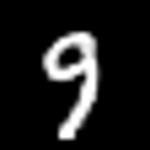


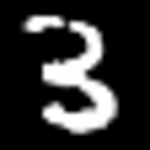
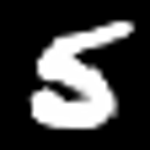
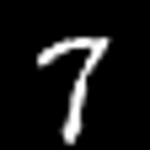
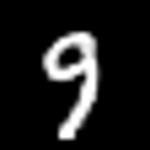

epoch  33



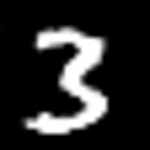
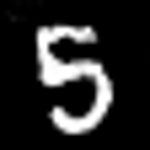
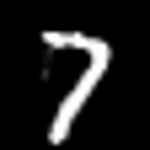
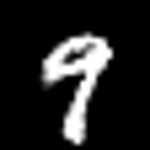


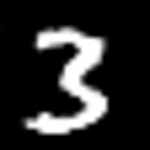
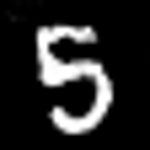
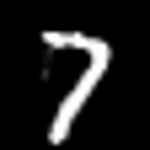
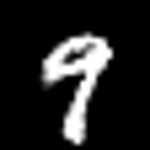

epoch  34



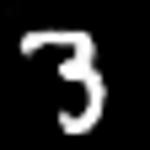
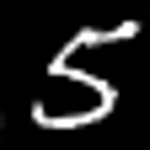
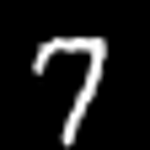
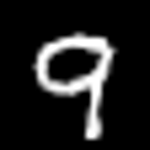


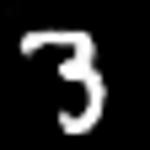
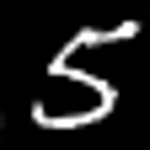
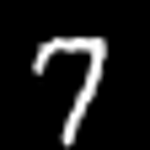
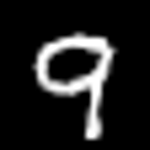

epoch  35



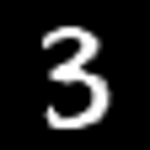
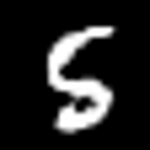
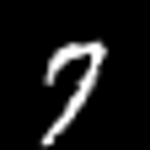
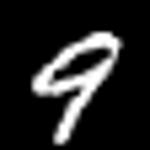


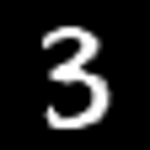
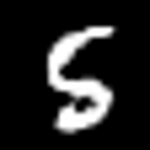
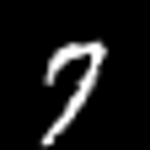
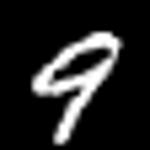

epoch  36



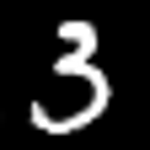
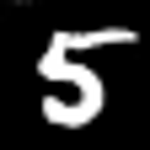
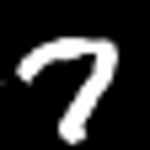
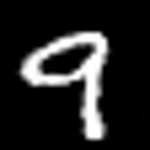


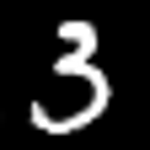
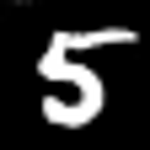
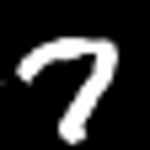
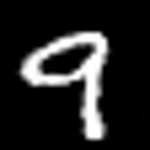

epoch  37



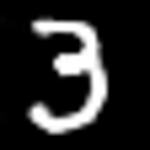
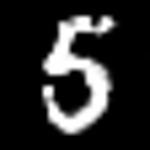
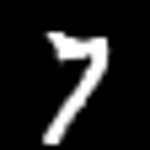
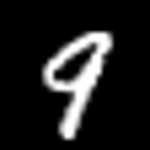


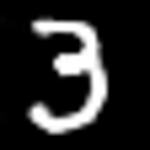
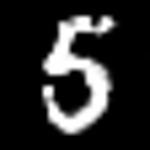
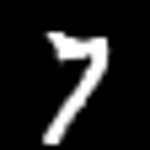
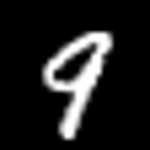

epoch  38



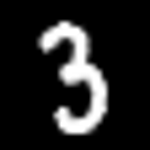
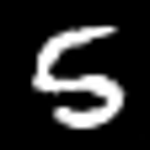
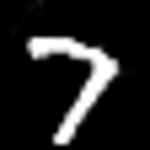
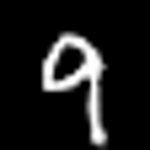


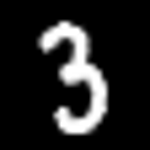
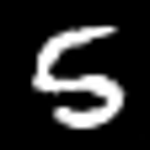
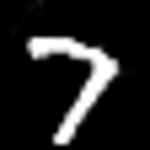
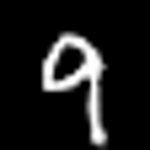

epoch  39



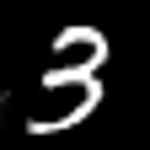
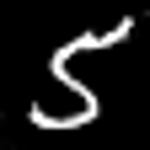
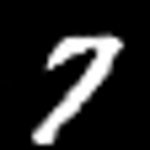
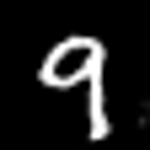


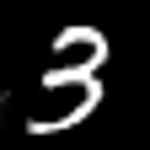
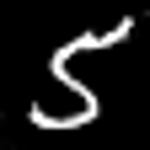
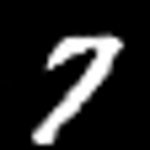
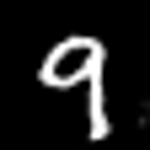

epoch  40



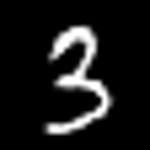
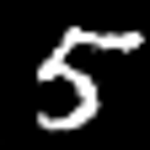
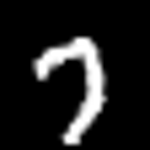
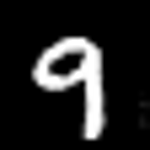


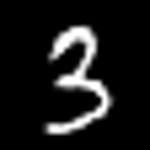
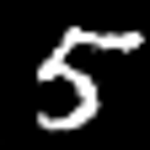
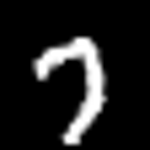
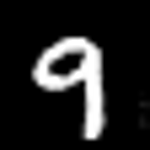

epoch  41



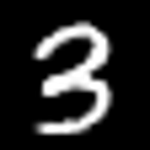
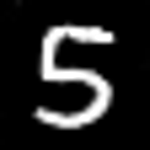
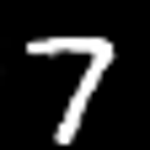
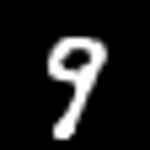


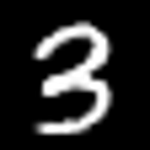
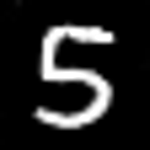
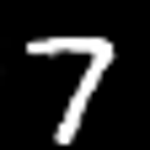
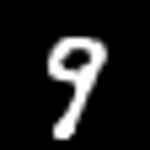

epoch  42



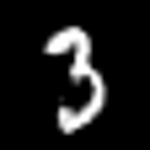
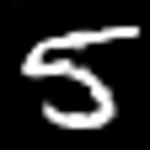
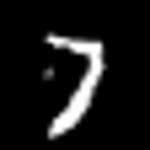
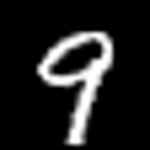


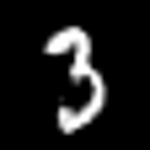
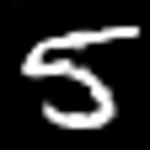
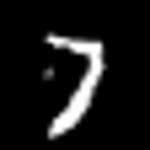
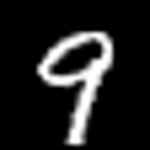

epoch  43



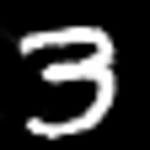
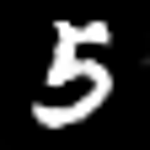
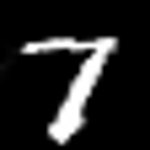
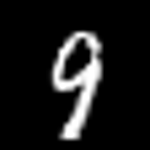


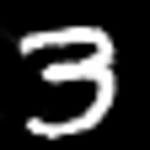
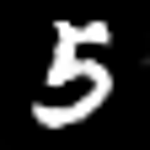
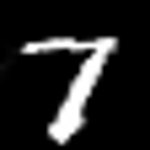
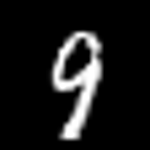

epoch  44



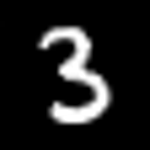
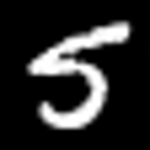
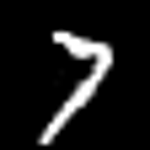
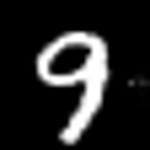


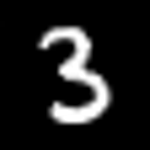
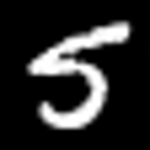
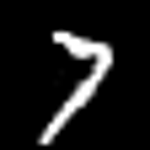
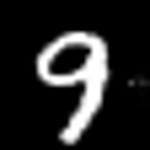

epoch  45



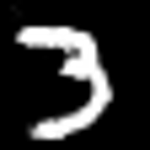
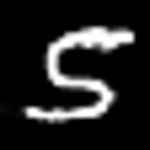
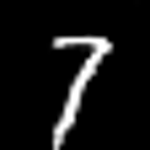
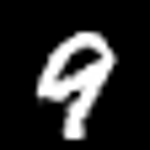


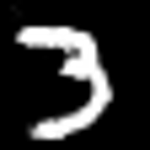
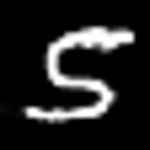
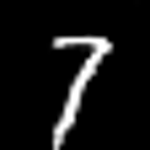
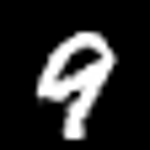

epoch  46



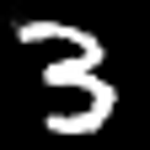
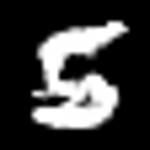
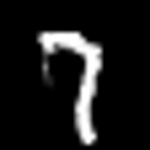
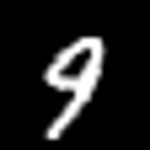


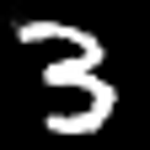
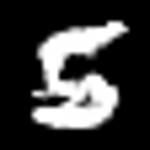
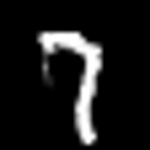
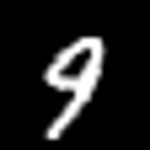

epoch  47



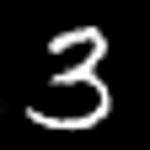
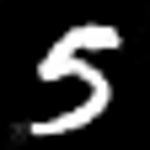
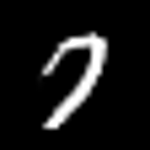
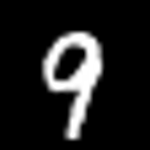


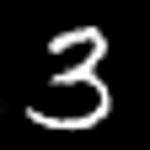
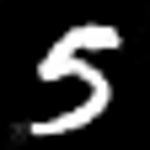
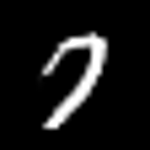
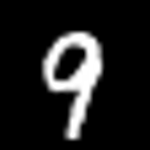

epoch  48



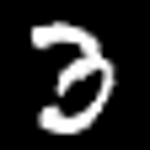
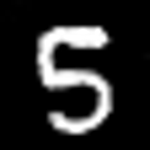
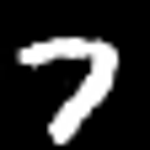
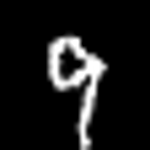


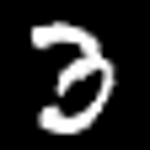
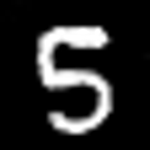
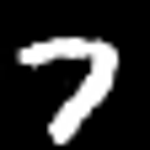
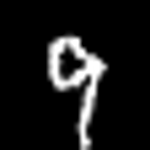

epoch  49



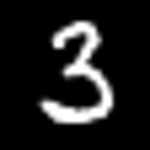
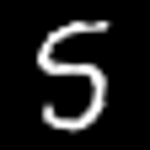
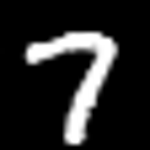
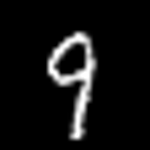


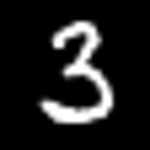
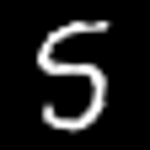
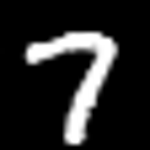
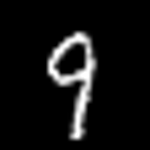

epoch  50



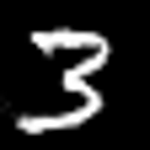
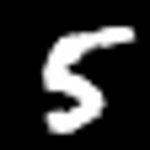
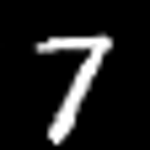
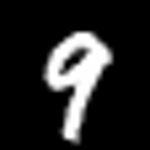


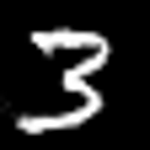
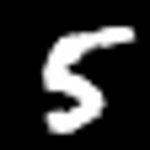
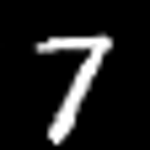
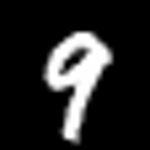

In [ ]:
epochs = 50 #số epochs
latent_dim =100 #số chiều cho noises
gan = Gan(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003,beta_1=0.5), 
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003,beta_1=0.5),
    loss_function=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=4, latent_dim=latent_dim)],verbose=0
    )